In [11]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from IPython import display
from tensorflow.python.data import Dataset
import math
tf.logging.set_verbosity(tf.logging.ERROR)
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import pandas_profiling
from time import gmtime, strftime
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


#### 1) Custom DNN regressor with estimator
#### 2) CNN sequential Keras API
#### 3) CNN functional Keras API

# 2) Data Processing

In [32]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [33]:
def preprocess_data(df_train):
    df_train_rand = df_train.reindex(np.random.permutation(df_train.index))
    return df_train_rand

In [34]:
def preprocess_features(x_train):
    #Normalization to greyscale, reduces the effect of illumination's differences
    x_train_norm = x_train / 255.0
    #Reshaping for keras 28x28x1 3D matrices?
    x_train_norm = x_train_norm.values.reshape(-1, 28, 28, 1)
    return x_train_norm

In [46]:
def preprocess_targets(y_train):
    #Encode labels to one hot vecs
    y_train_hot = to_categorical(y_train, num_classes=10)
    return y_train_hot

In [47]:
df_train_rand = preprocess_data(df_train)
X_train = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).head(38000).copy())
X_val = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).tail(6000).copy())
Y_train = preprocess_targets(df_train_rand['label'].head(38000).copy())
Y_val = preprocess_targets(df_train_rand['label'].tail(6000).copy())

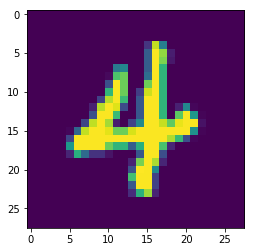

In [48]:
g = plt.imshow(X_train[0][:,:,0])

Filters are transformations of the image.
Filters' size is defined by kernel size


In [49]:
#Architecture:
#[[Conv2D->reulu]*2] -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Softmax
 
model = Sequential()

model.add(Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu',
                 input_shape = (28, 28, 1)))
#The model needs to know what input shape it should expect, the following layer can do automatic shape inference
# by counting the previous layers output shape? yes, we already have that number
# 2D layers such as dense support input_dim instead of input_shape
model.add(Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same',
                 activation = 'relu'))

model.add(MaxPool2D(pool_size=(2,2),
                   strides=(2,2)))
# it is typical to not have overlap during pooling, I intuit it is in order to reduce noise and duplication

model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'Same',
                activation = 'relu'))
model.add(Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'Same',
                activation = 'relu'))

model.add(MaxPool2D(pool_size=(2,2),
                    strides=(2,2)))


model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(245, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [50]:
# Optimizer, required for compiling a Keras model
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = None, decay = 0.0)

In [51]:
# optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)

In [52]:
# Compiling
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [53]:
# Learning rate reduction
# Keras has a list of callback functions which we can use to apply at different stages of training.
# We can pass the as the keyword argument 'callbacks' to the .fit() method of Sequential or Model classes
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, 
# the learning rate is reduced.
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                           patience = 3,
                                           verbose = 1,
                                           factore = 0.5,
                                           min_lr = 0.00001)

In [54]:
epochs = 10
batch_size = 80

In [55]:
# Data augmentation


In [ ]:
# Fit, returns a History object, its history attribute is a record of training loss values and metrics values at 
# sequential epochs, as well as validation loss values and validation metrics values
history = model.fit(X_train,
                    Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (X_val, Y_val),
                    verbose = 2)

Train on 38000 samples, validate on 6000 samples
Epoch 1/10
 - 151s - loss: 0.2303 - acc: 0.9267 - val_loss: 0.0551 - val_acc: 0.9837
Epoch 2/10
 - 146s - loss: 0.0744 - acc: 0.9778 - val_loss: 0.0368 - val_acc: 0.9880
Epoch 3/10
 - 148s - loss: 0.0583 - acc: 0.9831 - val_loss: 0.0281 - val_acc: 0.9898
Epoch 4/10
 - 148s - loss: 0.0483 - acc: 0.9861 - val_loss: 0.0276 - val_acc: 0.9912
Epoch 5/10
 - 147s - loss: 0.0411 - acc: 0.9875 - val_loss: 0.0258 - val_acc: 0.9907
Epoch 6/10
 - 146s - loss: 0.0368 - acc: 0.9894 - val_loss: 0.0242 - val_acc: 0.9927
Epoch 7/10
 - 147s - loss: 0.0348 - acc: 0.9898 - val_loss: 0.0160 - val_acc: 0.9947
Epoch 8/10
